In [4]:
#We are going to be talking about classification in this

#Classifying something is spam or not spam.
# -> Binary Classification : one thing or another
# -> Multiclass classification : more than one thing
# -> Multi Label Classification : multiple label options

## 1 Making some classification dara and get ready

import sklearn
from sklearn.datasets import make_circles

#Make a 1000 samples
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [5]:
len(X), len(y)

(1000, 1000)

In [6]:
print(f" First 5 samples of X :\n {X[:5]}")
print(f" First 5 samples of y :\n {y[:5]}")

 First 5 samples of X :
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
 First 5 samples of y :
 [1 1 1 1 0]


In [7]:
#y has either 0 or 1  - as it is binary classification
import pandas as pd
circles = pd.DataFrame({"X1" : X[:,0],
                        "X2" : X[:, 1],
                        "label" : y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


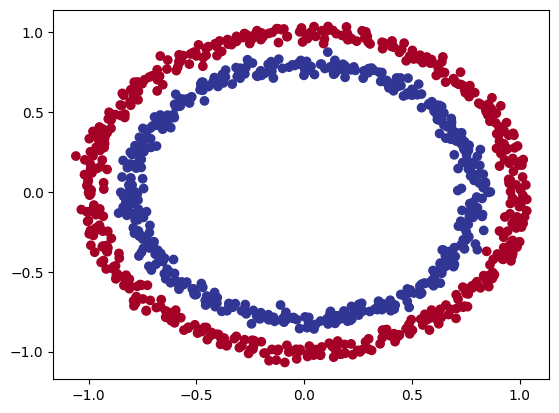

In [8]:
#Visualize

import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [9]:
#As we can see above, the toy dataset which is a small dataset
#The above coordinates are a coordinate of a circle

#Checking the input and the output shapes

X.shape, y.shape

((1000, 2), (1000,))

In [10]:
X

array([[ 0.75424625,  0.23148074],
       [-0.75615888,  0.15325888],
       [-0.81539193,  0.17328203],
       ...,
       [-0.13690036, -0.81001183],
       [ 0.67036156, -0.76750154],
       [ 0.28105665,  0.96382443]])

In [11]:
#We will need it in pytorch tensors
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X : {X_sample} and the same for y : {y_sample}")
print(f"Shapes for one sample of X : {X_sample.shape} and the same for y : {y_sample.shape}")


Values for one sample of X : [0.75424625 0.23148074] and the same for y : 1
Shapes for one sample of X : (2,) and the same for y : ()


In [12]:
# Converting into tensors
import torch
torch.__version__


'2.2.1+cu121'

In [13]:
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [14]:
X[:5]
torch.manual_seed(42)

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X, y,
                                                     test_size=0.2, #0.2 i.e 20% of the data has to be test
                                                    random_state= 42)
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

In [16]:
n_samples


1000

In [17]:
### Building the model
# 1) Building the model to classify the blue and the red dots
# 2) Setting up the devce agnostic code, i.e the code will run on the accelearator
# 3) Construct a model - by subclassing 'nn.Module'
# 4) Define the loss function and the optimizer
# 5) Creating a test loop

import torch
from torch import nn

#making device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [18]:
#Constructing the model
 # We will be subclassing the nn.Module, which is the neurel network model

 #Creating the two nn.Linear() layers that are capable of handling the shapes
 #Defining the forward method that outlines the forward pass
 #Instantiate the instance of the model class and send it to the target device

 # Constructing the model, that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    #Creating the 2 nn.Linear layers capable of handling the shapes of the data
    #takes in two features and upscales it to 5 features
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    #takes in 5 features from the layer above
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
  #forward method that outlines the forward path
  def forward(self, x):
    #layer 1 -> layer 2 -> output
    return self.layer_2(self.layer_1(x))

#Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

#Let us replicate the model above using nn.Sequential()
#We do not even need a class for the model in this case
model_0 = nn.Sequential(nn.Linear(in_features=2, out_features=5),
                                  nn.Linear(in_features=5, out_features=1)
                                  ).to(device)
model_0



Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cuda'

In [20]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [21]:
model_0.state_dict()


OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [22]:
#Making some predictions with the model
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of the predictions : {len(untrained_preds)}, shape : {untrained_preds.shape}")
  print(f"Length of the predictions : {len(X_test)}, shape : {X_test.shape}")
  print(f"First 10 predicitons  : {untrained_preds[:10]}")
  print(f"First 10 labels  : {y_test[:10]}")

Length of the predictions : 200, shape : torch.Size([200, 1])
Length of the predictions : 200, shape : torch.Size([200, 2])
First 10 predicitons  : tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')
First 10 labels  : tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [23]:
y_test[:10], X_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]))

In [24]:
## Setting up the loss function and the optimizer

#Loss function and optimizer  - we will have a different one
#For regression it is going to be MAE, and MGE
#For classification we want the binary cross entropy

#As a reminder the loss function shows how wrong the models are.
#And the optimizer, optimizes the model :) for optimizer we use SGD and the Adam optimizer

#For the loss function we are going to use the logits loss

#Setting up the loss function
#has the sigmoid activation function built in
#this is also usually more stable
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [25]:
#Calculating the accuracy - out of the 100 examples what percentage does our model get right
def accuracy_fn(y_true, y_preds):
  correct =torch.eq(y_true, y_preds).sum().item()
  acc = (correct/len(y_preds)) * 100
  return acc



In [26]:
##Training the model
#Similiar to the pytorch training loop

#Raw outputs of our model are logits. We can convert these logits to prediction probablities and we can convet them into probabilities by passing them into an actiavtion
#function like sigmoid for cross entropy above and softmax
# 1) Forward pass, 2) Calculate the loss 3) Calculate the zero grad 4) Loss backward 5) Optimizer

In [27]:
# we will be going from raw logits to predicition probabilities to prediciton labels

#model output -  raw logits
# logits -> prediction probabilties by passing them through an activation function  - sigmoid, softmax etc
# we can convert the model's prediciton probabilities to prediction labels by rounding them

#Viewing the first 5 outputs of the forward pass on the test data
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
  y_logits

y_logits


tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [28]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [29]:
#Using the sigmoid activation function on the model logits to turn them into prediciton probs
#We have to use the sigmoid function for the predicition probabilties
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [30]:
#For our prediciton probability value, we have to perform range-style rounding on them
#"y_preds_probs >= 0.5" - class 1
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

In [31]:
#Finding the predicited labels
y_preds = torch.round(y_pred_probs)
#in full logits -> pred_probs -> pred_labels
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

In [32]:
#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [33]:
#get rid of extra dimensions
y_preds.squeeze()
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [34]:
#Building a testing and a training loop
device

'cuda'

In [35]:
!nvidia-smi

Thu Apr 18 05:17:07 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0              26W /  70W |    151MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

In [37]:
#Setting the number of epochs
epochs = 100

#Putting the data to the target device
X_train, y_train, = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

#Building the training loop
for epoch in range(epochs):
  #Training
  model_0.train()

  #Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #turning logits into pred probs into pred labels

  #Calculating the loss or accuracy
  #We are using the BCRWithLossLogits in this as it is more numerically stable
  loss = loss_fn(y_logits, y_train) #nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

  #Optimizer
  optimizer.zero_grad()

  #Loss backward - backpropogation
  loss.backward()

  #Optimizer step  - reduce the gradients and the gradient descent
  optimizer.step()

  #testing
  model_0.eval()
  with torch.inference_mode():
    #this is basically forward pass in classification
    test_logits= model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #Calculating the test loss and accuracy
    test_loss  = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_preds=test_pred)

    #Print out what is happening
    if epoch % 10 == 0:
      print(f"Epoch : {epoch} | Loss : {loss: .5f}, Acc : {acc: .5f}% | Test loss : {test_loss: .5f}, Test acc : {test_acc: .5f} ")





Epoch : 0 | Loss :  0.69796, Acc :  51.87500% | Test loss :  0.69440, Test acc :  58.00000 
Epoch : 10 | Loss :  0.69590, Acc :  51.25000% | Test loss :  0.69305, Test acc :  53.00000 
Epoch : 20 | Loss :  0.69490, Acc :  51.62500% | Test loss :  0.69254, Test acc :  49.50000 
Epoch : 30 | Loss :  0.69435, Acc :  51.12500% | Test loss :  0.69236, Test acc :  49.50000 
Epoch : 40 | Loss :  0.69401, Acc :  50.87500% | Test loss :  0.69232, Test acc :  51.00000 
Epoch : 50 | Loss :  0.69378, Acc :  50.25000% | Test loss :  0.69234, Test acc :  50.00000 
Epoch : 60 | Loss :  0.69362, Acc :  50.00000% | Test loss :  0.69239, Test acc :  51.50000 
Epoch : 70 | Loss :  0.69351, Acc :  50.25000% | Test loss :  0.69246, Test acc :  51.00000 
Epoch : 80 | Loss :  0.69342, Acc :  49.87500% | Test loss :  0.69254, Test acc :  50.00000 
Epoch : 90 | Loss :  0.69336, Acc :  49.87500% | Test loss :  0.69262, Test acc :  53.00000 


In [38]:
#If the model's accurcy is 50% that basically means for a binary classification that it is just making a guess
#As you can see above, then it is not really learning anything in the inference
#As it is not learning anything, it is not a good model and we cannot make predicitions
#Making the predicitons and evaluate the model and making them visual
#to do som we will import a function called plot_decision_boundary

#we will get the function described above from this github repo - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py
import requests
from pathlib import Path

#Download the helper functions from the repo if it is not already downloaded
if Path("helper_functions.py").is_file():
  print("Helper functions already exist")
else:
  print("Downloading helper_functions.py")
  request   = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content) #getting all of the code with the helper_functions.py

from helper_functions import plot_predictions, plot_decision_boundary

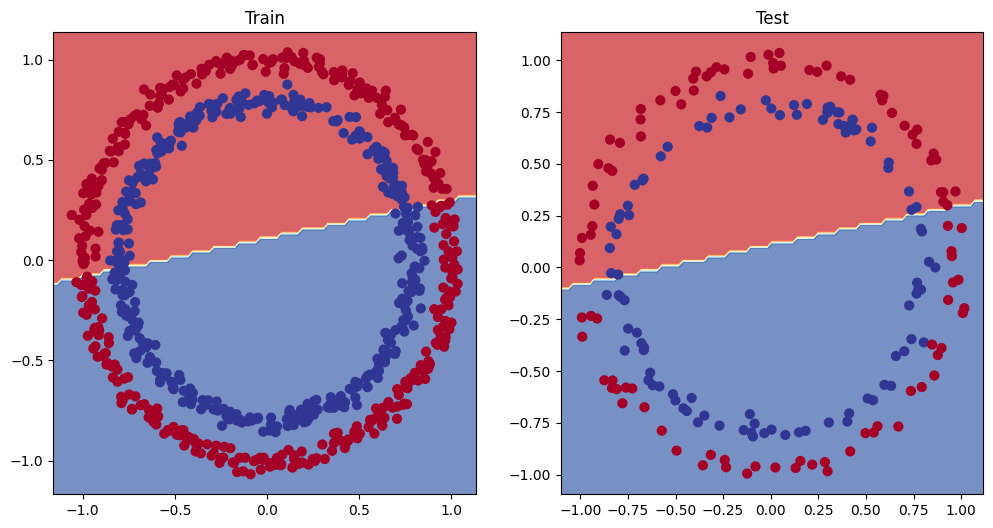

In [39]:
#Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [40]:
##How can we improve the model
# Adding more layers so that the model can learn from forward and backpropogation
#Adding more hidden units (i.e hidden layer's building neuron)
#Fit for longer, so increase th epochs
#Changing the activation functions
#Change the learning rate or lr
#Changing the loss function

In [41]:
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]], device='cuda:0'),
 tensor([1., 0., 0., 0., 1.], device='cuda:0'))

In [42]:
#Let's improve our model by adding more hidden units(5->10), increasing more layers
#2 -> 3 layers and increase the number of epochs from 100 -> 1000
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x)))
   #The above way of writing the operations just makes it faster and intuitive to implement

model_1 = CircleModelV1().to(device)


In [43]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [45]:
#Picking up a loss function
loss_fn = nn.BCEWithLogitsLoss()

#Creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1 )

#Writing a training and evaluation loop for the model_1
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs=1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  #logits -> prediciton probabilities -> predicitions

  #Calculating the loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_preds=y_pred)

  #Optimizer using the zero grad
  optimizer.zero_grad()

  #Loss backward  - backpropogation
  loss.backward()

  #Optimizer step - gradient descent
  optimizer.step()

  model_1.eval()
#testing the model_1
  with torch.inference_mode():
    #using the forward pass
    test_logits = model_1(X_test).squeeze()
    #Calculating the loss
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_preds=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss : {loss: .5f} | Acc: {acc:.2f} | Test Loss : {test_loss:.5f} | Test Acc: {test_acc: .5f}")



Epoch: 0 | Loss :  0.69396 | Acc: 50.88 | Test Loss : 0.69261 | Test Acc:  51.00000
Epoch: 100 | Loss :  0.69305 | Acc: 50.38 | Test Loss : 0.69379 | Test Acc:  48.00000
Epoch: 200 | Loss :  0.69299 | Acc: 51.12 | Test Loss : 0.69437 | Test Acc:  46.00000
Epoch: 300 | Loss :  0.69298 | Acc: 51.62 | Test Loss : 0.69458 | Test Acc:  45.00000
Epoch: 400 | Loss :  0.69298 | Acc: 51.12 | Test Loss : 0.69465 | Test Acc:  46.00000
Epoch: 500 | Loss :  0.69298 | Acc: 51.00 | Test Loss : 0.69467 | Test Acc:  46.00000
Epoch: 600 | Loss :  0.69298 | Acc: 51.00 | Test Loss : 0.69468 | Test Acc:  46.00000
Epoch: 700 | Loss :  0.69298 | Acc: 51.00 | Test Loss : 0.69468 | Test Acc:  46.00000
Epoch: 800 | Loss :  0.69298 | Acc: 51.00 | Test Loss : 0.69468 | Test Acc:  46.00000
Epoch: 900 | Loss :  0.69298 | Acc: 51.00 | Test Loss : 0.69468 | Test Acc:  46.00000


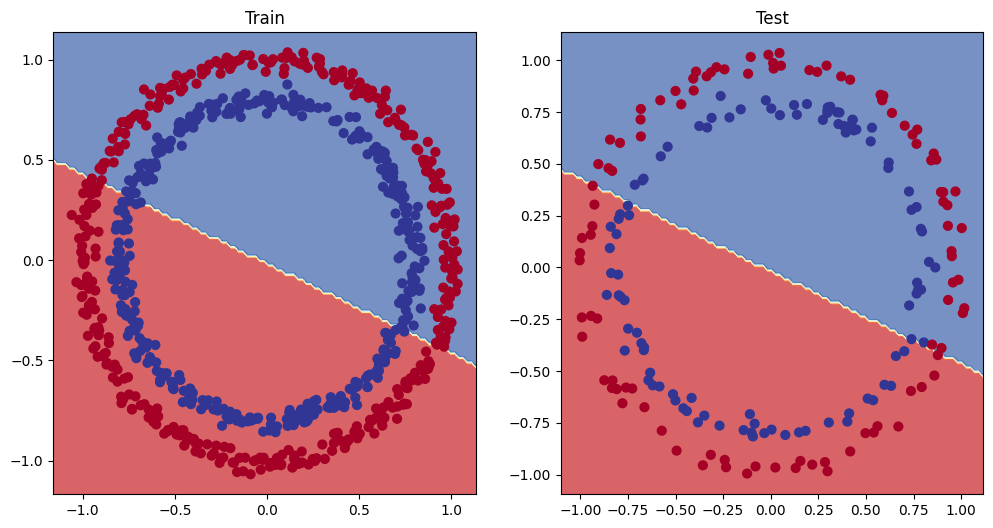

In [46]:
#Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [47]:
##Preparing the data to see if our model can even fit a straight line

#One way to trouble shoot a larget problem is to test out the smaller model

#Creating some data - same as the notebook 01
weight = 0.7
bias = 0.3
start = 0
end=1
step=0.01

X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [48]:
#Create the train and the test splits
train_split = int(0.8* len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(X_test_regression), len(y_test_regression), len(y_train_regression)

(80, 20, 20, 80)

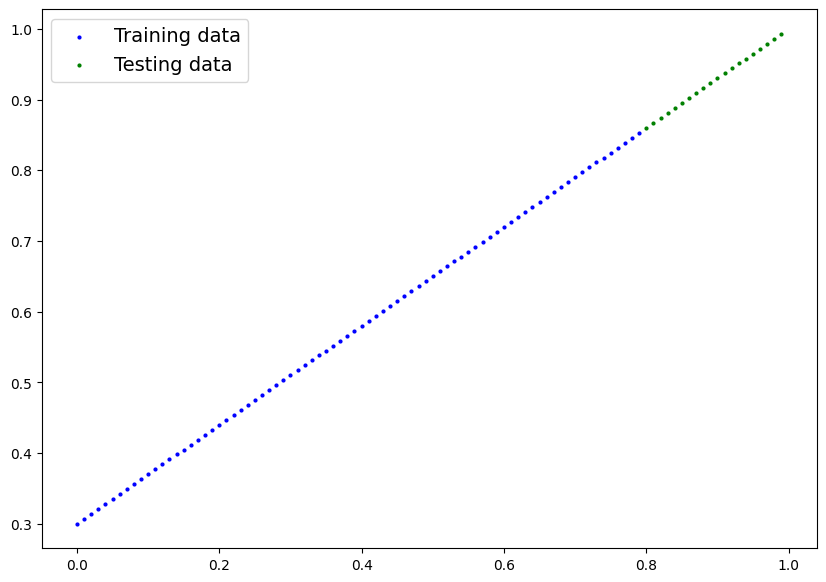

In [49]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [50]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [51]:
#The issue with this could be a linear layer which cannot be used for our data as it is
# not linear.
##Adjusting the model_1 to fit it into a straight line

#This will have the same architecture as model_1 but using nn.Sequential

model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)



).to(device)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [52]:
#Loss and optimizer
loss_fn = nn.L1Loss() #as it is a regression problem
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.01)


In [53]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

#Putting the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

#training through the epochs
for epoch in range(epochs):

  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss : {loss:.5f} | Test Loss : {test_loss: .5f}")


Epoch: 0 | Loss : 0.75986 | Test Loss :  0.91103
Epoch: 100 | Loss : 0.02858 | Test Loss :  0.00081
Epoch: 200 | Loss : 0.02533 | Test Loss :  0.00209
Epoch: 300 | Loss : 0.02137 | Test Loss :  0.00305
Epoch: 400 | Loss : 0.01964 | Test Loss :  0.00341
Epoch: 500 | Loss : 0.01940 | Test Loss :  0.00387
Epoch: 600 | Loss : 0.01903 | Test Loss :  0.00379
Epoch: 700 | Loss : 0.01878 | Test Loss :  0.00381
Epoch: 800 | Loss : 0.01840 | Test Loss :  0.00329
Epoch: 900 | Loss : 0.01798 | Test Loss :  0.00360


In [55]:
#Turn on the evaluation mode
model_2.eval()

#Making predicitons
with torch.inference_mode():
  y_preds = model_2(X_test_regression.cpu())

plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(),
                    test_data=X_test_regression.cpu(),
                      test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu())

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

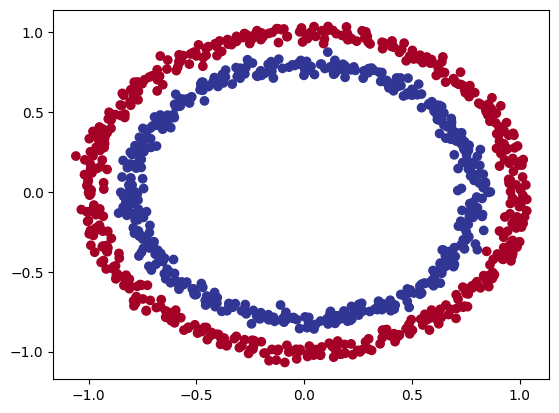

In [56]:
#### Non Linear functions to be used
#The above graph shows that our model does have capacity to predict

#The missing piece of our model was non linearity
#What pattersn could you draw if you were given infinite amount of straight/non straight line
#In case of machine learning , using infinite amount of linear and non linear functions

##Making and plotting the data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
n_samples=1000
X, y = make_circles(n_samples=1000,
                      noise=0.03,
                    random_state=42)
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.RdYlBu);

In [57]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [58]:
X_train[:10], y_train[:10]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994],
         [-0.8837, -0.4678],
         [-0.3836,  0.6987],
         [ 0.6047,  0.5163],
         [-0.5869,  0.7804],
         [ 0.8833, -0.5178]]),
 tensor([1., 0., 0., 0., 1., 0., 1., 1., 0., 0.]))

In [59]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [60]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [61]:
model_3.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.3041, -0.0775],
                      [-0.5293,  0.6441],
                      [-0.5190,  0.3779],
                      [ 0.2485,  0.2298],
                      [-0.3823,  0.6427],
                      [ 0.1554,  0.0910],
                      [-0.6231,  0.2968],
                      [-0.1061, -0.3239],
                      [ 0.6074,  0.1576],
                      [-0.3912, -0.3579]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.0338,  0.3948, -0.1807, -0.4035, -0.2421, -0.5283,  0.2522,  0.5473,
                      -0.6657,  0.1642], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.1634,  0.0573, -0.1126,  0.1651,  0.1662,  0.1182, -0.0556, -0.0837,
                        0.0338, -0.0559],
                      [-0.0942,  0.2021,  0.2718, -0.0313, -0.0708,  0.0046, -0.0189,  0.0760,
                        0.0886, -0.2872],
                      [-0.1167,  0.266

In [62]:
# Artificial neural networks are large combination of linear and non linear functions
# which are potentially able to find the patterns in the data.


#Setup the loss and the optimizer

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

# this is for binary classification only, two choices presented to you in the first
## Training the model with non linearity



In [63]:
# Fit the model
torch.manual_seed(42)
epochs = 2000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_preds=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_preds=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69441, Accuracy: 50.00% | Test Loss: 0.69360, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69162, Accuracy: 55.12% | Test Loss: 0.69052, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.69074, Accuracy: 50.88% | Test Loss: 0.68922, Test Accuracy: 54.00%
Epoch: 300 | Loss: 0.68975, Accuracy: 51.38% | Test Loss: 0.68775, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68863, Accuracy: 51.38% | Test Loss: 0.68614, Test Accuracy: 56.00%
Epoch: 500 | Loss: 0.68733, Accuracy: 52.00% | Test Loss: 0.68439, Test Accuracy: 56.00%
Epoch: 600 | Loss: 0.68575, Accuracy: 54.75% | Test Loss: 0.68246, Test Accuracy: 57.50%
Epoch: 700 | Loss: 0.68375, Accuracy: 59.75% | Test Loss: 0.68028, Test Accuracy: 62.00%
Epoch: 800 | Loss: 0.68108, Accuracy: 56.75% | Test Loss: 0.67768, Test Accuracy: 58.00%
Epoch: 900 | Loss: 0.67760, Accuracy: 58.63% | Test Loss: 0.67459, Test Accuracy: 60.00%
Epoch: 1000 | Loss: 0.67298, Accuracy: 59.62% | Test Loss: 0.67067, Test Accuracy: 59.50%
Epoch: 1100 | Loss: 0.

In [64]:
#Making predictions - the most recent mode
model_3.eval()
with torch.inference_mode():
  y_preds=torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

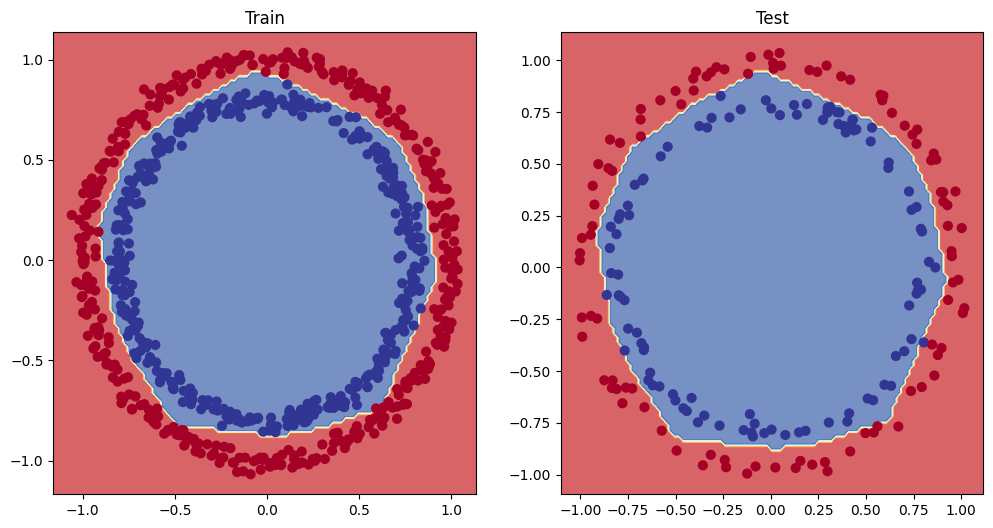

In [65]:
#Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

In [66]:
#Replicating non linear activation functions
#We give it tools, and the model tries ot figure everything out
#The tools are linear and non linear functions

#Creating a tensor

A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

In [67]:
A


tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

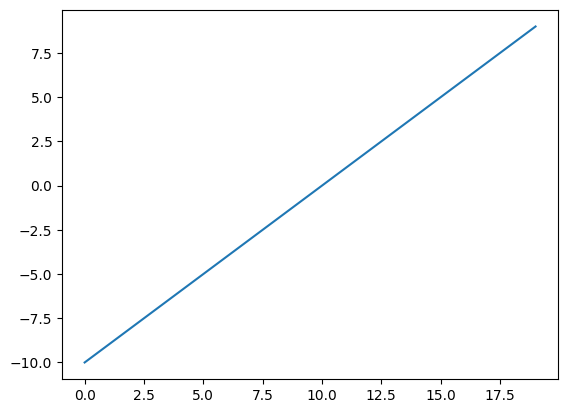

In [68]:
#Visualizing this data
plt.plot(A)

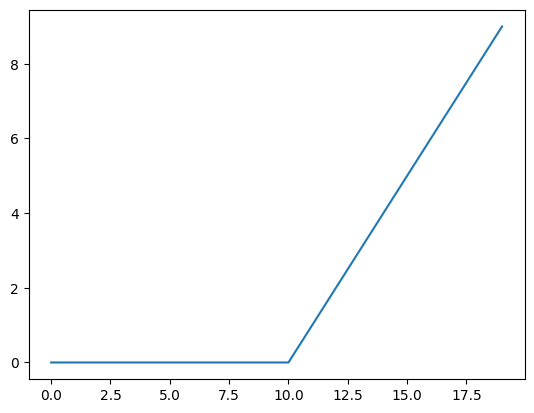

In [69]:
plt.plot(torch.relu(A))

In [70]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.max(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

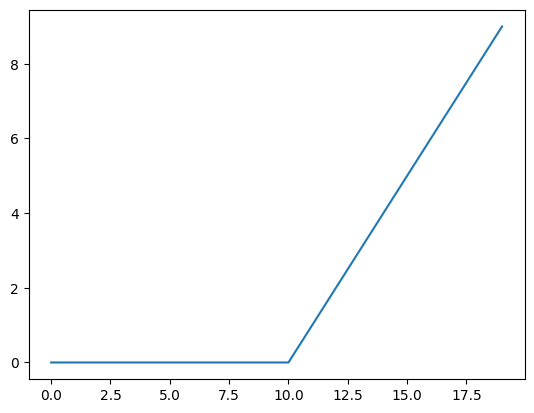

In [71]:
#Plotting ReLU activation function
plt.plot(torch.relu(A))

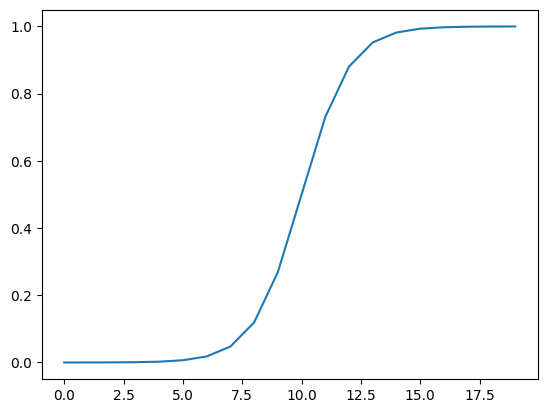

In [72]:
#Doing the same for sigmoid
def sigmoid(x):
  return 1/(1+torch.exp(-x))

plt.plot(torch.sigmoid(A))

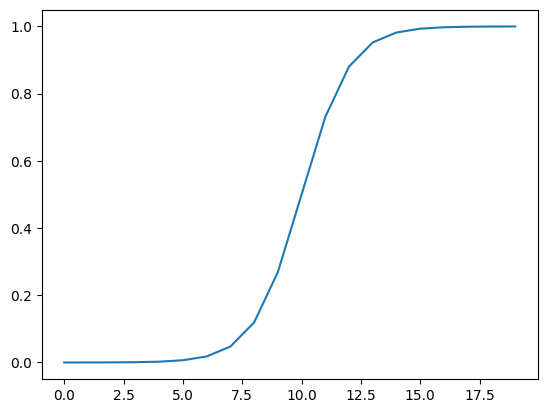

In [73]:
plt.plot(sigmoid(A))

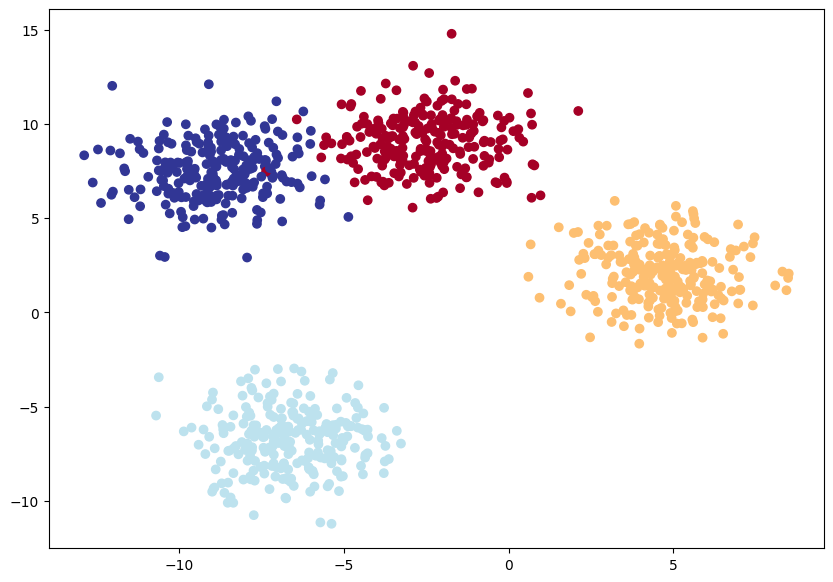

In [111]:
#### Working with multi class classifications
#Creating a toy multi class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


#Creating multi class data
X_blob, y_blob  = make_blobs(n_samples=1000, n_features=NUM_FEATURES,
                                          centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)


#^Gives us  the clusters

#Turning data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

#Split into train, test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                            test_size=0.2,
                                                                        random_state=RANDOM_SEED)

#PLotting the data - Visualizing data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

In [112]:
##Building a multi class classification model in Pytorch

#Creating a device agnostic code
device='cuda' if torch.cuda.is_available() else 'cpu'
device


'cuda'

In [113]:
#Building a multi class classification model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    #Initializes multi class classification model
    #Args - input_features (int) - number of input features
    #output_features (int): Number of output features  - number of output classes
    #hidden_units(int) : number of hidden units between the layers

    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_features)


    )
  def forward(self, x):
    return self.linear_layer_stack(x)



In [114]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [115]:
model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)

In [116]:
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [117]:
## Create a loss function and a optimizer for a multiclass classification
# We will be looking an Cross Entropy loss in this case
#Computes the cross entopy loss between input and target
device = 'cuda' if torch.cuda.is_available() else "cpu"
device
#Creating a loss function for multi class classification
loss_fn = nn.CrossEntropyLoss()

#Creating an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)
# learning rate is a hyper parameter you can possibnly change

## Getting prediction probabilities  - raw outputs of our model

#Getting some raw putputs of our model
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))

y_logits[:10]


tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287],
        [-0.4885, -2.0119, -0.4004, -1.3252],
        [ 0.2586, -0.8477,  0.2739, -0.8695],
        [ 0.6816, -1.1144,  0.2053, -0.6434],
        [ 0.3433, -1.0156,  0.4706, -1.1226],
        [ 0.7687, -1.0243,  0.2629, -0.5887]], device='cuda:0')

In [118]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [119]:
# In order to evaluate, train and test our model we have to convert our model outputs
# to prediction probablities

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287]], device='cuda:0')
tensor([[0.4236, 0.1221, 0.2895, 0.1648],
        [0.3694, 0.0873, 0.3767, 0.1666],
        [0.3509, 0.1235, 0.4076, 0.1179],
        [0.3627, 0.1506, 0.2965, 0.1902],
        [0.5084, 0.0806, 0.2882, 0.1228]], device='cuda:0')


In [120]:
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0')

In [121]:
torch.max(y_pred_probs[0])

tensor(0.4236, device='cuda:0')

In [122]:
#This will give the actual tensor index for the prediction
torch.argmax(y_pred_probs[0])

tensor(0, device='cuda:0')

In [126]:
#Logits = raw outputs of the model -> pred probs (uses torch.softmax) ->
# pred labels  - take the argmax of the prediction prob.

##Creating a training a testing loop for a multi class pytorch model
import torch
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set number of epochs
epochs = 100

#put data into the target device

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train, y_preds=y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ## testing code
  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test, y_preds=test_preds)

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {test_loss: .5f} | Acc: {test_acc:.5f} | Test Loss: {test_loss: .5f} Test Acc: {test_acc: .2f}")



Epoch: 0 | Loss:  0.85675 | Acc: 77.50000 | Test Loss:  0.85675 Test Acc:  77.50
Epoch: 10 | Loss:  0.50326 | Acc: 79.50000 | Test Loss:  0.50326 Test Acc:  79.50
Epoch: 20 | Loss:  0.38913 | Acc: 79.00000 | Test Loss:  0.38913 Test Acc:  79.00
Epoch: 30 | Loss:  0.31870 | Acc: 86.00000 | Test Loss:  0.31870 Test Acc:  86.00
Epoch: 40 | Loss:  0.26133 | Acc: 90.50000 | Test Loss:  0.26133 Test Acc:  90.50
Epoch: 50 | Loss:  0.18780 | Acc: 99.00000 | Test Loss:  0.18780 Test Acc:  99.00
Epoch: 60 | Loss:  0.10981 | Acc: 99.00000 | Test Loss:  0.10981 Test Acc:  99.00
Epoch: 70 | Loss:  0.06846 | Acc: 99.00000 | Test Loss:  0.06846 Test Acc:  99.00
Epoch: 80 | Loss:  0.05069 | Acc: 99.00000 | Test Loss:  0.05069 Test Acc:  99.00
Epoch: 90 | Loss:  0.04188 | Acc: 99.00000 | Test Loss:  0.04188 Test Acc:  99.00


In [128]:
#Plot decision boundary of the model
#Making and evaluating with the pytorch multi class token

model_3.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]


tensor([[ 0.9858,  5.0800, -2.3882, -0.9470],
        [-1.5492, -6.6938, -8.1743,  3.7651],
        [-3.8204, -3.0508,  5.2422, -2.5335],
        [-0.1620,  3.6700, -1.3887, -0.4009],
        [ 6.1052,  2.6647, -5.1828, -2.0127],
        [-2.2356, -8.2865, -9.5581,  4.7309],
        [-3.6156, -2.8646,  4.8828, -2.3418],
        [ 5.1406, -0.2566, -6.1045, -0.7965],
        [-4.3851, -3.6586,  6.3366, -3.1613],
        [ 5.3924,  0.7937, -5.6710, -1.2245]], device='cuda:0')

In [129]:
#Going from logits to prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.6347e-02, 9.8073e-01, 5.5994e-04, 2.3662e-03],
        [4.8965e-03, 2.8550e-05, 6.4959e-06, 9.9507e-01],
        [1.1583e-04, 2.5006e-04, 9.9921e-01, 4.1945e-04],
        [2.0733e-02, 9.5686e-01, 6.0800e-03, 1.6325e-02],
        [9.6865e-01, 3.1045e-02, 1.2130e-05, 2.8881e-04],
        [9.4201e-04, 2.2193e-06, 6.2220e-07, 9.9906e-01],
        [2.0351e-04, 4.3127e-04, 9.9864e-01, 7.2743e-04],
        [9.9287e-01, 4.4967e-03, 1.2978e-05, 2.6207e-03],
        [2.2057e-05, 4.5614e-05, 9.9986e-01, 7.4996e-05],
        [9.8871e-01, 9.9515e-03, 1.5499e-05, 1.3225e-03]], device='cuda:0')

In [131]:
## Going from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_pred[:10]
## This will be exactly like y_preds_probs

tensor([1, 0, 2, 2, 0, 0, 0, 1, 3, 0], device='cuda:0')

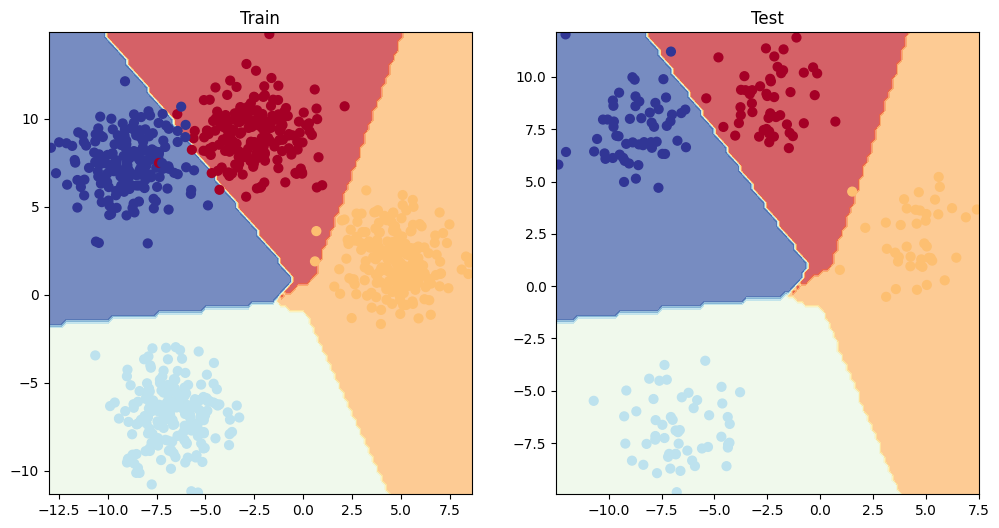

In [132]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

In [134]:
## Other classification metrics

## accuracy is one of the ways we see the metrics of how the classification model perfomred
## Precision
## Recall
## Confusion matrix
## Classification report

from sklearn.metrics import confusion_matrix
print("Confusion Matrix : ")
#The matrix basically means that in the class 0 the model got almost all the points accurate except one
# for the second one, we got 40 of the points accurately classified etc..
## Thus as you can see this classification was very accurate with almost >99% accuraccy
confusion_matrix(y_preds.to("cpu").round().reshape(-1).detach(),y_blob_test.to("cpu"))

Confusion Matrix : 


array([[49,  1,  0,  1],
       [ 0, 40,  0,  0],
       [ 0,  0, 53,  0],
       [ 0,  0,  0, 56]])

  Using cached torchmetrics-1.3.2-py3-none-any.whl (841 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
ERROR: Operation cancelled by user
